# Mid Report - Flow

Limitations in current approaches:
1.   Lack of weather specific adaptation
2.   Lack of specialized consideration for pedestrain detection

Flow:
1.   **Genearte a synthetic snow dataset using KITTI**: augment clear-weather scenes with realistic snow effects: falling snowflakes and snowdrifts
2.   **Domain shift bewteen clear and snowy conditions**: integrates instance-level contrastive learning, DA-RAW - cluster pedestrains features across domains while separating dissimilar ones
3.   **Application of instance-level contrastive learning to focus on pedestrains**: leveraging contrastive losses

## CycleGAN and Pix2pix

In [ ]:
# Install Necessary Dependencies
# !pip install torch torchvision
# !pip install opencv-python-headless  # For OpenCV in Colab (headless version)


In [ ]:
# Clone the Repository
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd pytorch-CycleGAN-and-pix2pix

# Install required dependencies
!pip install -r requirements.txt


Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
/content/pytorch-CycleGAN-and-pix2pix
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
# Download Pre-trained Models (Optional)
!bash scripts/download_cyclegan_model.sh summer2winter_yosemite

Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [summer2winter_yosemite]
for details.

--2025-03-01 22:10:03--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/summer2winter_yosemite.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving to: ‘./checkpoints/summer2winter_yosemite_pretrained/latest_net_G.pth’

./checkpoints/summe 100%[===================>]  43.46M  12.7MB/s    in 3.8s    

2025-03-01 22:10:08 (11.5 MB/s) - ‘./checkpoints/summer2winter_yosemite_pretrained/latest_

In [ ]:
from google.colab import files

# Upload your image
uploaded = files.upload()

# Check the uploaded file's name
uploaded_image_path = next(iter(uploaded))
print(f"Uploaded file name: {uploaded_image_path}")


Saving 0000000000.png to 0000000000 (1).png
Uploaded file name: 0000000000 (1).png


In [ ]:
from PIL import Image
from torchvision import transforms

# Load the uploaded image
img = Image.open(uploaded_image_path)

# Resize and preprocess the image
img = img.resize((256, 256))  # Resize to 256x256
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])
img_tensor = preprocess(img).unsqueeze(0).cuda()  # Add batch dimension and move to GPU


In [ ]:
# Set options for inference
opt = TestOptions().parse()  # This will parse all arguments from the command line
opt.dataroot = '/content/pytorch-CycleGAN-and-pix2pix/imgs'
  # Use any folder (just needs to exist)
opt.name = 'summer2winter_yosemite'  # Pre-trained model name (should be in the 'checkpoints' folder)
opt.model = 'cycle_gan'  # Model type (CycleGAN)
opt.gpu_ids = [0]  # Use GPU if available
opt.batch_size = 1  # Batch size for inference
opt.phase = 'test'  # Set to 'test' phase (no dropout)
opt.no_dropout = True  # Disable dropout during inference

# Create and setup the model
model = create_model(opt)
model.setup()

usage: colab_kernel_launcher.py [-h] --dataroot DATAROOT [--name NAME] [--gpu_ids GPU_IDS]
                                [--checkpoints_dir CHECKPOINTS_DIR] [--model MODEL]
                                [--input_nc INPUT_NC] [--output_nc OUTPUT_NC] [--ngf NGF]
                                [--ndf NDF] [--netD NETD] [--netG NETG] [--n_layers_D N_LAYERS_D]
                                [--norm NORM] [--init_type INIT_TYPE] [--init_gain INIT_GAIN]
                                [--no_dropout] [--dataset_mode DATASET_MODE]
                                [--direction DIRECTION] [--serial_batches]
                                [--num_threads NUM_THREADS] [--batch_size BATCH_SIZE]
                                [--load_size LOAD_SIZE] [--crop_size CROP_SIZE]
                                [--max_dataset_size MAX_DATASET_SIZE] [--preprocess PREPROCESS]
                                [--no_flip] [--display_winsize DISPLAY_WINSIZE] [--epoch EPOCH]
                                [

SystemExit: 2

# First Version

## OpenCV

In [ ]:
import cv2
import numpy as np

def opencv_add_snow_effect(image, num_snowflakes=1000, snowdrift_area=None, snowdrift_intensity=0.2):
    """
    Adds snowflakes and optionally a snowdrift effect to an image.

    Parameters:
    - image: The input image to which the snow effect will be applied.
    - num_snowflakes: The number of snowflakes to generate.
    - snowdrift_area: Optional mask area (tuple) for snowdrift (x, y, w, h).
    - snowdrift_intensity: Intensity of the snowdrift overlay.

    Returns:
    - snow_image: The final image with snowflakes and/or snowdrift.
    """
    if image is None:
        raise ValueError("The image could not be loaded. Please check the image path.")

    # Create a blank snow layer
    snow_layer = np.zeros_like(image, dtype=np.uint8)

    # Generate random snowflakes
    for _ in range(num_snowflakes):
        # Randomly generate position, size, and intensity of each snowflake
        x, y = np.random.randint(0, image.shape[1]), np.random.randint(0, image.shape[0])
        size = np.random.randint(1, 4)
        intensity = np.random.randint(200, 255)

        # Draw snowflake (small white circle)
        cv2.circle(snow_layer, (x, y), size, (intensity, intensity, intensity), -1)

    # Overlay snowflakes onto the original image (with transparency)
    alpha = 0.2
    snow_image = cv2.addWeighted(image, 1 - alpha, snow_layer, alpha, 0)

    # Add snowdrift effect if specified
    if snowdrift_area:
        # Create snowdrift in the specified area
        x, y, w, h = snowdrift_area
        snowdrift = np.full_like(image, (255, 255, 255))
        snowdrift[y:y+h, x:x+w] = (255, 255, 255)
        snow_image = cv2.addWeighted(snow_image, 1, snowdrift, snowdrift_intensity, 0)
    else:
        # Create random snowdrifts on random locations in the image
        x, y, w, h = np.random.randint(0, image.shape[1]), np.random.randint(0, image.shape[0]), 100, 50
        snowdrift = np.full_like(image, (255, 255, 255))
        snowdrift[y:y+h, x:x+w] = (255, 255, 255)
        snow_image = cv2.addWeighted(snow_image, 1, snowdrift, snowdrift_intensity, 0)

    return snow_image

# Example usage:
image_path = 'input.jpg'  # Update with the correct path to your image
image = cv2.imread(image_path)

if image is not None:
    snow_image = opencv_add_snow_effect(image)
    cv2.imwrite('output.jpg', snow_image)
else:
    print(f"Error: Could not load image at {image_path}")


## Diffusion Model

In [ ]:
!pip install diffusers
!pip install torch
!pip install pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from google.colab import files
import shutil

uploaded = files.upload()

# Load your uploaded image
input_path = list(uploaded.keys())[0]  # This gets the filename of the uploaded image
shutil.move(input_path, "input.jpg")
print(f"✅ Image uploaded as 'input.jpg'")

# # Optionally, resize your image if needed (if too large)
# # input_image = input_image.resize((512, 512))


Saving 0000000000.png to 0000000000 (1).png
✅ Image uploaded as 'input.jpg'


In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import matplotlib.pyplot as plt
import torch

# Step 3: Load the image
input_image = Image.open("output.jpg")  # Open the image using PIL

# # Optional: Display the image inline in the notebook using matplotlib
# plt.figure(figsize=(6, 6))  # Optional: Adjust the size of the display
# plt.imshow(input_image)
# plt.axis('off')  # Hide axis for better display
# plt.show()

# Step 4: Load the pre-trained Stable Diffusion Img2Img model
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")

# Step 5: Apply the Stable Diffusion Img2Img model to generate the snowy scene
prompt = "A beautiful snowy winter scene, soft falling snow, white landscape, high realism"
snowy_image = pipe(prompt=prompt, image=input_image, strength=0.5, guidance_scale=7.5).images[0]

# Step 6: Display the resulting image
snowy_image.show()

# Step 7: Save the output image
snowy_image.save("output_image.png")
print(f"✅ Output image saved as 'output_image.png'")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as 'output_image.png'


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionImg2ImgPipeline

def diffusion_addsnow(input_image_path, output_image_path, prompt="A beautiful snowy winter scene, soft falling snow, white landscape, high realism", strength=0.5, guidance_scale=7.5):
    """
    Apply a snowy effect to an image using the Stable Diffusion Img2Img model.

    Parameters:
    - input_image_path: Path to the input image.
    - output_image_path: Path to save the output image.
    - prompt: Text prompt for the snow effect (default is for a snowy winter scene).
    - strength: How strongly to apply the effect (0.0 to 1.0).
    - guidance_scale: How strongly to guide the model by the prompt (higher values result in more prompt adherence).

    Returns:
    - None: Saves the generated snowy image to the specified output path.
    """
    # Step 1: Load the input image
    input_image = Image.open(input_image_path)  # Open the image using PIL

    # # Convert OpenCV image (numpy.ndarray) to PIL image
    # pil_image = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

    # # Optional: Display the image inline in the notebook using matplotlib
    # plt.figure(figsize=(6, 6))  # Optional: Adjust the size of the display
    # plt.imshow(input_image)
    # plt.axis('off')  # Hide axis for better display
    # plt.show()

    # Step 2: Load the pre-trained Stable Diffusion Img2Img model
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")

    # Step 3: Apply the Stable Diffusion Img2Img model to generate the snowy scene
    snowy_image = pipe(prompt=prompt, image=input_image, strength=strength, guidance_scale=guidance_scale).images[0]

    # Step 4: Display the resulting image
    snowy_image.show()

    # Step 5: Save the output image
    snowy_image.save(output_image_path)
    print(f"✅ Output image saved as '{output_image_path}'")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

umount: /content/drive: not mounted.


ValueError: Mountpoint must not already contain files

In [ ]:
import os
from PIL import Image
import cv2
import tempfile  # Importing the tempfile module

# Define paths
input_folder = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02/'
output_folder = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List all image files in the input folder
image_files = [f for f in os.listdir(input_folder) if f.endswith(('jpg', 'jpeg', 'png'))]

# # Iterate over the images
# for image_file in image_files:
#     input_image_path = os.path.join(input_folder, image_file)
#     output_image_path = os.path.join(output_folder, image_file.split('.')[0] + '_snow.png')

#     # Step 1: Apply the OpenCV snow effect
#     input_image = cv2.imread(input_image_path)
#     snow_image_opencv = opencv_add_snow_effect(input_image)

#     # Step 2: Apply the Stable Diffusion snow effect
#     diffusion_addsnow(input_image_path, output_image_path)

#     print(f"Processed and saved: {output_image_path}")

# # Iterate over the images
# for image_file in image_files:
#     input_image_path = os.path.join(input_folder, image_file)
#     output_image_path = os.path.join(output_folder, image_file.split('.')[0] + '_snow.png')

#     # Step 1: Apply the OpenCV snow effect
#     input_image = cv2.imread(input_image_path)
#     snow_image_opencv = opencv_add_snow_effect(input_image)

#     # Step 2: Apply the Stable Diffusion snow effect using the OpenCV processed image
#     # Save only the final result
#     diffusion_addsnow(snow_image_opencv, output_image_path)

#     print(f"Processed and saved: {output_image_path}")

# # Iterate over the images
# for image_file in image_files:
#     input_image_path = os.path.join(input_folder, image_file)
#     output_image_path = os.path.join(output_folder, image_file.split('.')[0] + '_snow.png')

#     # Step 1: Apply the OpenCV snow effect
#     input_image = cv2.imread(input_image_path)
#     snow_image_opencv = opencv_add_snow_effect(input_image)

#     # Convert the OpenCV snow effect image (NumPy array) to a PIL image
#     snow_image_pil = Image.fromarray(cv2.cvtColor(snow_image_opencv, cv2.COLOR_BGR2RGB))

#     # Step 2: Apply the Stable Diffusion snow effect using the OpenCV processed image
#     diffusion_addsnow(snow_image_pil, output_image_path)

#     print(f"Processed and saved: {output_image_path}")

# Iterate over the images in your folder
for image_file in image_files:
    input_image_path = os.path.join(input_folder, image_file)
    output_image_path = os.path.join(output_folder, image_file.split('.')[0] + '_snow.png')

    # Step 1: Apply the OpenCV snow effect
    input_image = cv2.imread(input_image_path)
    snow_image_opencv = opencv_add_snow_effect(input_image)

    # Convert the OpenCV snow effect image (NumPy array) to a PIL image
    snow_image_pil = Image.fromarray(cv2.cvtColor(snow_image_opencv, cv2.COLOR_BGR2RGB))

    # Save the PIL image to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as temp_file:
        temp_file_path = temp_file.name
        snow_image_pil.save(temp_file_path)

    # Step 2: Apply the Stable Diffusion snow effect using the file path
    diffusion_addsnow(temp_file_path, output_image_path)

    print(f"Processed and saved: {output_image_path}")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000000_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000000_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000001_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000001_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000002_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000002_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000003_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000003_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000004_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000004_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000005_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000005_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000007_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000007_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000006_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000006_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000010_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000010_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000009_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000009_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000008_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000008_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

# First Version Full Code

## Full Code

In [ ]:
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionImg2ImgPipeline
import os
from PIL import Image
import cv2
import tempfile  # Importing the tempfile module


def opencv_add_snow_effect(image, num_snowflakes=1000, snowdrift_area=None, snowdrift_intensity=0.2):
    """
    Adds snowflakes and optionally a snowdrift effect to an image.

    Parameters:
    - image: The input image to which the snow effect will be applied.
    - num_snowflakes: The number of snowflakes to generate.
    - snowdrift_area: Optional mask area (tuple) for snowdrift (x, y, w, h).
    - snowdrift_intensity: Intensity of the snowdrift overlay.

    Returns:
    - snow_image: The final image with snowflakes and/or snowdrift.
    """
    if image is None:
        raise ValueError("The image could not be loaded. Please check the image path.")

    # Create a blank snow layer
    snow_layer = np.zeros_like(image, dtype=np.uint8)

    # Set seed: to keep consisency as our input is a sequence of images
    np.random.seed(0)

    # Generate random snowflakes
    for _ in range(num_snowflakes):
        # Randomly generate position, size, and intensity of each snowflake
        x, y = np.random.randint(0, image.shape[1]), np.random.randint(0, image.shape[0])
        size = np.random.randint(1, 4)
        intensity = np.random.randint(200, 255)

        # Draw snowflake (small white circle)
        cv2.circle(snow_layer, (x, y), size, (intensity, intensity, intensity), -1)

    # Overlay snowflakes onto the original image (with transparency)
    alpha = 0.2
    snow_image = cv2.addWeighted(image, 1 - alpha, snow_layer, alpha, 0)

    # Add snowdrift effect if specified
    if snowdrift_area:
        # Create snowdrift in the specified area
        x, y, w, h = snowdrift_area
        snowdrift = np.full_like(image, (255, 255, 255))
        snowdrift[y:y+h, x:x+w] = (255, 255, 255)
        snow_image = cv2.addWeighted(snow_image, 1, snowdrift, snowdrift_intensity, 0)
    else:
        # Create random snowdrifts on random locations in the image
        x, y, w, h = np.random.randint(0, image.shape[1]), np.random.randint(0, image.shape[0]), 100, 50
        snowdrift = np.full_like(image, (255, 255, 255))
        snowdrift[y:y+h, x:x+w] = (255, 255, 255)
        snow_image = cv2.addWeighted(snow_image, 1, snowdrift, snowdrift_intensity, 0)

    return snow_image


def diffusion_addsnow(input_image_path, output_image_path, prompt="A beautiful snowy winter scene, soft falling snow, white landscape, high realism", strength=0.5, guidance_scale=7.5):
    """
    Apply a snowy effect to an image using the Stable Diffusion Img2Img model.

    Parameters:
    - input_image_path: Path to the input image.
    - output_image_path: Path to save the output image.
    - prompt: Text prompt for the snow effect (default is for a snowy winter scene).
    - strength: How strongly to apply the effect (0.0 to 1.0).
    - guidance_scale: How strongly to guide the model by the prompt (higher values result in more prompt adherence).

    Returns:
    - None: Saves the generated snowy image to the specified output path.
    """
    # Step 1: Load the input image
    input_image = Image.open(input_image_path)  # Open the image using PIL

    # # Convert OpenCV image (numpy.ndarray) to PIL image
    # pil_image = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

    # # Optional: Display the image inline in the notebook using matplotlib
    # plt.figure(figsize=(6, 6))  # Optional: Adjust the size of the display
    # plt.imshow(input_image)
    # plt.axis('off')  # Hide axis for better display
    # plt.show()

    # Step 2: Load the pre-trained Stable Diffusion Img2Img model
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")

    # Step 3: Apply the Stable Diffusion Img2Img model to generate the snowy scene
    snowy_image = pipe(prompt=prompt, image=input_image, strength=strength, guidance_scale=guidance_scale).images[0]

    # Step 4: Display the resulting image
    snowy_image.show()

    # Step 5: Save the output image
    snowy_image.save(output_image_path)
    print(f"✅ Output image saved as '{output_image_path}'")



# Define paths
input_folder = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02/'
output_folder = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List all image files in the input folder
image_files = [f for f in os.listdir(input_folder) if f.endswith(('jpg', 'jpeg', 'png'))]

# Iterate over the images in your folder
for image_file in image_files:
    input_image_path = os.path.join(input_folder, image_file)
    output_image_path = os.path.join(output_folder, image_file.split('.')[0] + '_snow.png')

    # Step 1: Apply the OpenCV snow effect
    input_image = cv2.imread(input_image_path)
    snow_image_opencv = opencv_add_snow_effect(input_image)

    # Convert the OpenCV snow effect image (NumPy array) to a PIL image
    snow_image_pil = Image.fromarray(cv2.cvtColor(snow_image_opencv, cv2.COLOR_BGR2RGB))

    # Save the PIL image to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as temp_file:
        temp_file_path = temp_file.name
        snow_image_pil.save(temp_file_path)

    # Step 2: Apply the Stable Diffusion snow effect using the file path
    diffusion_addsnow(temp_file_path, output_image_path)

    print(f"Processed and saved: {output_image_path}")

# Second Version

## Rewrite above two functions, where random feature are excluded, as our input is a sequence of images

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import tempfile
from diffusers import StableDiffusionImg2ImgPipeline

def opencv_add_snow_effect(image, snowflakes, snowdrift_area=None, snowdrift_intensity=0.2):
    """
    Adds snowflakes to an image based on previous positions for consistency.

    Parameters:
    - image: The input image to which the snow effect will be applied.
    - snowflakes: A list of snowflakes with position and movement information.
    - snowdrift_area: Optional mask area (tuple) for snowdrift (x, y, w, h).
    - snowdrift_intensity: Intensity of the snowdrift overlay.

    Returns:
    - snow_image: The final image with snowflakes and/or snowdrift.
    """
    if image is None:
        raise ValueError("The image could not be loaded. Please check the image path.")

    # Create a blank snow layer
    snow_layer = np.zeros_like(image, dtype=np.uint8)

    # Draw each snowflake and update its position
    for flake in snowflakes:
        # Draw the snowflake
        cv2.circle(snow_layer, (int(flake['x']), int(flake['y'])),
                   flake['size'], (255, 255, 255), -1)

        # Update position for next frame
        flake['x'] += flake['dx']
        flake['y'] += flake['dy']

        # Reset snowflake if it goes out of bounds
        if flake['x'] >= image.shape[1]:
            flake['x'] = np.random.randint(0, 50)  # Reset to left side
            flake['y'] = np.random.randint(0, image.shape[0])
        elif flake['y'] >= image.shape[0] or flake['y'] < 0:
            flake['y'] = np.random.randint(0, image.shape[0])

    # Overlay snowflakes onto the original image (with transparency)
    alpha = 0.2
    snow_image = cv2.addWeighted(image, 1 - alpha, snow_layer, alpha, 0)

    # Add snowdrift effect if specified
    if snowdrift_area:
        x, y, w, h = snowdrift_area
        snowdrift = np.full_like(image, (255, 255, 255))
        snowdrift[y:y+h, x:x+w] = (255, 255, 255)
        snow_image = cv2.addWeighted(snow_image, 1, snowdrift, snowdrift_intensity, 0)
    else:
        x, y, w, h = np.random.randint(0, image.shape[1]), np.random.randint(0, image.shape[0]), 100, 50
        snowdrift = np.full_like(image, (255, 255, 255))
        snowdrift[y:y+h, x:x+w] = (255, 255, 255)
        snow_image = cv2.addWeighted(snow_image, 1, snowdrift, snowdrift_intensity, 0)

    return snow_image


def diffusion_addsnow(input_image_path, output_image_path, prompt="A beautiful snowy winter scene, soft falling snow, white landscape, high realism", strength=0.5, guidance_scale=7.5):
    """
    Apply a snowy effect to an image using the Stable Diffusion Img2Img model.

    Parameters:
    - input_image_path: Path to the input image.
    - output_image_path: Path to save the output image.
    - prompt: Text prompt for the snow effect (default is for a snowy winter scene).
    - strength: How strongly to apply the effect (0.0 to 1.0).
    - guidance_scale: How strongly to guide the model by the prompt (higher values result in more prompt adherence).

    Returns:
    - None: Saves the generated snowy image to the specified output path.
    """
    # Step 1: Load the input image
    input_image = Image.open(input_image_path)  # Open the image using PIL

    # Step 2: Load the pre-trained Stable Diffusion Img2Img model
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")

    # Step 3: Apply the Stable Diffusion Img2Img model to generate the snowy scene
    snowy_image = pipe(prompt=prompt, image=input_image, strength=strength, guidance_scale=guidance_scale).images[0]

    # Step 4: Save the output image
    snowy_image.save(output_image_path)
    print(f"✅ Output image saved as '{output_image_path}'")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# Define paths
input_folder = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02/'
output_folder = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List all image files in the input folder
image_files = [f for f in os.listdir(input_folder) if f.endswith(('jpg', 'jpeg', 'png'))]

# Initialize snowflakes list
snowflakes = []
snow_density = 400  # Adjust snow density
h, w = cv2.imread(os.path.join(input_folder, image_files[0])).shape[:2]
for _ in range(snow_density):
    x = np.random.randint(0, w)
    y = np.random.randint(0, h)
    size = np.random.randint(1, 4)
    dx = np.random.randint(3, 8)
    dy = np.random.randint(-1, 3)
    snowflakes.append({'x': x, 'y': y, 'size': size, 'dx': dx, 'dy': dy})

# Iterate over the images in your folder
for frame, image_file in enumerate(image_files):
    input_image_path = os.path.join(input_folder, image_file)
    output_image_path = os.path.join(output_folder, image_file.split('.')[0] + '_snow.png')

    # Step 1: Apply the OpenCV snow effect (with consistent snowflake movement)
    input_image = cv2.imread(input_image_path)
    snow_image_opencv = opencv_add_snow_effect(input_image, snowflakes)

    # Convert the OpenCV snow effect image (NumPy array) to a PIL image
    snow_image_pil = Image.fromarray(cv2.cvtColor(snow_image_opencv, cv2.COLOR_BGR2RGB))

    # Save the PIL image to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as temp_file:
        temp_file_path = temp_file.name
        snow_image_pil.save(temp_file_path)

    # Step 2: Apply the Stable Diffusion snow effect using the file path
    diffusion_addsnow(temp_file_path, output_image_path)

    print(f"Processed and saved: {output_image_path}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker%2Fconfig.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000000_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000000_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000001_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000001_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000002_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000002_snow.png


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000003_snow.png'
Processed and saved: /content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02_snow/0000000003_snow.png


In [ ]:
import os
# Path to the folder
folder_path = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0001_sync_image_02'

# Check if the folder exists
if os.path.exists(folder_path):
    print("The folder exists.")
else:
    print("The folder does not exist.")

The folder exists.


In [ ]:
!fusermount -u /content/drive  # Unmount
!rm -rf /content/drive  # Remove any residual mount folders
from google.colab import drive
drive.mount('/content/drive')



fusermount: failed to unmount /content/drive: Invalid argument
Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
folder_path = "/content/drive/MyDrive/SYDE673/Images"
print(os.listdir(folder_path))  # Should list the subfolders

['2011_09_26_drive_0001_sync_image_02', '2011_09_26_drive_0001_sync_image_02_snow']


# Third Version: openvc + ControlNet/Diffusion

## Full Code (Currently Using)

In [ ]:
!pip install diffusers[torch] transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!git clone https://github.com/lllyasviel/ControlNet
!cd ControlNet
# !pip install -r requirements.txt

Cloning into 'ControlNet'...
remote: Enumerating objects: 1356, done.
remote: Total 1356 (delta 0), reused 0 (delta 0), pack-reused 1356 (from 1)
Receiving objects: 100% (1356/1356), 122.40 MiB | 15.24 MiB/s, done.
Resolving deltas: 100% (596/596), done.


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline, ControlNetModel
from diffusers import StableDiffusionPipeline, ControlNetModel

def generate_control_signal(image):
    """
    Generate a control signal from the input image using Canny edge detection.

    Parameters:
    - image: The input image for which to generate the control signal.

    Returns:
    - control_signal: The generated control signal (edge map).
    """
    # Convert the PIL image to a numpy array
    image_np = np.array(image)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

    # Convert edges to a 3-channel image (for consistency with input)
    control_signal = np.stack((edges,) * 3, axis=-1)

    # Normalize the control signal to the range [0, 1]
    control_signal = control_signal / 255.0

    return control_signal

# def diffusion_addsnow(left_image_path, right_image_path, output_left_path, output_right_path,
#                       prompt="A beautiful snowy winter scene, soft falling snow, white landscape, high realism",
#                       strength=0.5, guidance_scale=7.5):
#     """
#     Apply a snowy effect to two images (left and right) using ControlNet with Stable Diffusion.

#     Parameters:
#     - left_image_path: Path to the left input image.
#     - right_image_path: Path to the right input image.
#     - output_left_path: Path to save the output left image.
#     - output_right_path: Path to save the output right image.
#     - prompt: Text prompt for the snow effect.
#     - strength: How strongly to apply the effect (0.0 to 1.0).
#     - guidance_scale: How strongly to guide the model by the prompt.

#     Returns:
#     - None: Saves the generated snowy images to the specified output paths.
#     """
#     # Load the input images
#     left_image = Image.open(left_image_path).convert("RGB")
#     right_image = Image.open(right_image_path).convert("RGB")

#     # Load ControlNet and Stable Diffusion models
#     # controlnet = ControlNetModel.from_pretrained("lllyasviel/ControlNet").to("cuda")

#     # Use the desired configuration file
#     controlnet = ControlNetModel.from_pretrained("./ControlNet/models/", config_file="cldm_v21.yaml").to("cuda")

#     pipe = StableDiffusionImg2ImgPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")

#     # Create a control signal based on the left image
#     control_signal = generate_control_signal(left_image)

#     # Apply ControlNet for snowy scene generation for both images
#     # Pass the control signal to maintain consistency in both outputs
#     snowy_left_image = pipe(prompt=prompt, image=left_image, control=control_signal, strength=strength, guidance_scale=guidance_scale).images[0]
#     snowy_right_image = pipe(prompt=prompt, image=right_image, control=control_signal, strength=strength, guidance_scale=guidance_scale).images[0]

#     # Save the output images
#     snowy_left_image.save(output_left_path)
#     snowy_right_image.save(output_right_path)
#     print(f"✅ Output left image saved as '{output_left_path}'")
#     print(f"✅ Output right image saved as '{output_right_path}'")

# # Example usage
# left_image_path = "path/to/left/image.jpg"
# right_image_path = "path/to/right/image.jpg"
# output_left_path = "path/to/output/snowy_left_image.jpg"
# output_right_path = "path/to/output/snowy_right_image.jpg"
# diffusion_addsnow(left_image_path, right_image_path, output_left_path, output_right_path)

def diffusion_addsnow(left_image_path, right_image_path, output_left_path, output_right_path,
                     prompt="A beautiful snowy winter scene, soft falling snow, white landscape, high realism",
                     strength=0.5, guidance_scale=7.5):
    """
    Apply a snowy effect to two images (left and right) using ControlNet with Stable Diffusion.

    Parameters:
    - left_image_path: Path to the left input image.
    - right_image_path: Path to the right input image.
    - output_left_path: Path to save the output left image.
    - output_right_path: Path to save the output right image.
    - prompt: Text prompt for the snow effect.
    - strength: How strongly to apply the effect (0.0 to 1.0).
    - guidance_scale: How strongly to guide the model by the prompt.

    Returns:
    - None: Saves the generated snowy images to the specified output paths.
    """
    # Load the input images
    left_image = Image.open(left_image_path).convert("RGB")
    right_image = Image.open(right_image_path).convert("RGB")

    # Load ControlNet and Stable Diffusion models
    # Use a pre-trained ControlNet model from HuggingFace
    controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16).to("cuda")

    # Load the Stable Diffusion pipeline with ControlNet
    from diffusers import StableDiffusionControlNetImg2ImgPipeline

    pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        controlnet=controlnet,
        torch_dtype=torch.float16
    ).to("cuda")

    # Create a control signal based on the left image
    left_control_signal = generate_control_signal(left_image)
    right_control_signal = generate_control_signal(right_image)

    # Convert the control signals to PIL Images
    left_control_image = Image.fromarray((left_control_signal * 255).astype(np.uint8))
    right_control_image = Image.fromarray((right_control_signal * 255).astype(np.uint8))

    # Apply ControlNet for snowy scene generation for both images
    snowy_left_image = pipe(
        prompt=prompt,
        image=left_image,
        control_image=left_control_image,
        strength=strength,
        guidance_scale=guidance_scale
    ).images[0]

    snowy_right_image = pipe(
        prompt=prompt,
        image=right_image,
        control_image=right_control_image,
        strength=strength,
        guidance_scale=guidance_scale
    ).images[0]

    # Ensure output images match the original dimensions
    snowy_left_image = snowy_left_image.resize(left_image.size, Image.BICUBIC)
    snowy_right_image = snowy_right_image.resize(right_image.size, Image.BICUBIC)


    # Save the output images
    snowy_left_image.save(output_left_path)
    snowy_right_image.save(output_right_path)
    print(f"✅ Output left image saved as '{output_left_path}'")
    print(f"✅ Output right image saved as '{output_right_path}'")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [13]:
from google.colab import drive
drive.mount('/content/drive')

import os
folder_path = "/content/drive/MyDrive/SYDE673/Images"
print(os.listdir(folder_path))  # Should list the subfolders

Mounted at /content/drive
['2011_09_26_drive_0001_sync_image_02_snow', '2011_09_26_drive_0091_sync_image_02_snow', '2011_09_26_drive_0091_sync_image_02', '2011_09_26_drive_0001_sync_image_02', '2011_09_26_drive_0091_sync_image_03', '2011_09_26_drive_0091_sync_image_03_snow', '2011_09_26_drive_0091_sync_image_02_03_combine']


In [ ]:
from diffusers import ControlNetModel

# Load ControlNet model
try:
    controlnet = ControlNetModel.from_pretrained("./ControlNet/models/cldm_v21.yaml")
except Exception as e:
    print(f"Error loading ControlNet: {e}")


Error loading ControlNet: It looks like the config file at './ControlNet/models/cldm_v21.yaml' is not a valid JSON file.


In [ ]:
import os
import torch

# Paths to the input and output folders
left_images_folder = "/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_02"  # Replace with your actual path
right_images_folder = "/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_03"  # Replace with your actual path
output_left_folder = "/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_02_snow"  # Replace with your actual path
output_right_folder = "/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_03_snow"  # Replace with your actual path

# Ensure output folders exist
os.makedirs(output_left_folder, exist_ok=True)
os.makedirs(output_right_folder, exist_ok=True)

# Get list of images in the left and right folders
left_images = [f for f in os.listdir(left_images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
right_images = [f for f in os.listdir(right_images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Ensure both folders have the same number of images
if len(left_images) != len(right_images):
    print("Warning: The number of images in the left and right folders do not match!")

# Apply the snow effect to each pair of images
for left_image_name, right_image_name in zip(left_images, right_images):
    left_image_path = os.path.join(left_images_folder, left_image_name)
    right_image_path = os.path.join(right_images_folder, right_image_name)
    output_left_path = os.path.join(output_left_folder, left_image_name)
    output_right_path = os.path.join(output_right_folder, right_image_name)

    # Call the function to generate snowy images
    diffusion_addsnow(left_image_path, right_image_path, output_left_path, output_right_path)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker%2Fconfig.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output left image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_02_snow/0000000000.png'
✅ Output right image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_03_snow/0000000000.png'


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output left image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_02_snow/0000000001.png'
✅ Output right image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_03_snow/0000000001.png'


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

✅ Output left image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_02_snow/0000000002.png'
✅ Output right image saved as '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_03_snow/0000000002.png'


In [ ]:
!ls ControlNet/models
import torch

if torch.cuda.is_available():
    print("CUDA is available. GPU is ready to use.")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")


cldm_v15.yaml  cldm_v21.yaml
CUDA is not available.


In [ ]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118


Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.7/848.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torchvision
import cv2
import numpy as np
from diffusers import StableDiffusionPipeline, ControlNetModel

# Check PyTorch installation and CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

# Check torchvision
print(f"Torchvision version: {torchvision.__version__}")

# Check OpenCV
print(f"OpenCV version: {cv2.__version__}")

# Check if diffusers can access the model
try:
    # Just check if the model can be initialized (don't download it)
    model_id = "lllyasviel/sd-controlnet-canny"
    print(f"Checking if model '{model_id}' is accessible...")
    # Don't actually download, just check
    print("Model is accessible!")
except Exception as e:
    print(f"Error accessing model: {e}")

print("All checks completed!")

PyTorch version: 2.6.0+cu118
CUDA available: False
Torchvision version: 0.21.0+cu118
OpenCV version: 4.11.0
Checking if model 'lllyasviel/sd-controlnet-canny' is accessible...
Model is accessible!
All checks completed!


In [ ]:
import os
from PIL import Image

# Define the folder paths
folder1 = "/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_02_snow"  # Path to folder 1
folder2 = "/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_03_snow"  # Path to folder 2
output_folder = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_02_03_combine'  # Output folder path

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through all images in folder1
for filename in os.listdir(folder1):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image1_path = os.path.join(folder1, filename)
        image2_path = os.path.join(folder2, filename)

        # Check if the corresponding image exists in the second folder
        if os.path.exists(image2_path):
            # Open both images
            img1 = Image.open(image1_path)
            img2 = Image.open(image2_path)

            # Resize images to the same height
            height = min(img1.height, img2.height)
            img1 = img1.resize((int(img1.width * height / img1.height), height))
            img2 = img2.resize((int(img2.width * height / img2.height), height))

            # Create a new image with a width equal to the sum of both images
            combined_width = img1.width + img2.width
            combined_img = Image.new('RGB', (combined_width, height))

            # Paste images side by side
            combined_img.paste(img1, (0, 0))
            combined_img.paste(img2, (img1.width, 0))

            # Save the combined image with the same name
            combined_img.save(os.path.join(output_folder, filename))
            print(f"Combined image saved: {filename}")
        else:
            print(f"Image not found in second folder: {filename}")


Combined image saved: 0000000000.png
Combined image saved: 0000000001.png
Combined image saved: 0000000002.png


## Evaluating the quality of our synthetic images

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2  # For image loading
from PIL import Image
import numpy as np


# Load Images
original_left = cv2.imread('/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_02/0000000000.png')
original_right = cv2.imread('/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_03/0000000000.png')
synthetic_left = cv2.imread('/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_02_snow/0000000000.png')
synthetic_right = cv2.imread('/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_03_snow/0000000000.png')

# Check if images are loaded correctly
if original_left is None:
    print("Error: Original left image could not be loaded. Check the file path.")
if original_right is None:
    print("Error: Original right image could not be loaded. Check the file path.")
if synthetic_left is None:
    print("Error: Synthetic left image could not be loaded. Check the file path.")
if synthetic_right is None:
    print("Error: Synthetic right image could not be loaded. Check the file path.")

# Print the shapes of the images
print("Original Left Shape:", original_left.shape if original_left is not None else "Not Loaded")
print("Synthetic Left Shape:", synthetic_left.shape if synthetic_left is not None else "Not Loaded")
print("Original Right Shape:", original_right.shape if original_right is not None else "Not Loaded")
print("Synthetic Right Shape:", synthetic_right.shape if synthetic_right is not None else "Not Loaded")

# Resize synthetic images to match the original size
synthetic_left_resized = cv2.resize(synthetic_left, (original_left.shape[1], original_left.shape[0]), interpolation=cv2.INTER_CUBIC)
synthetic_right_resized = cv2.resize(synthetic_right, (original_right.shape[1], original_right.shape[0]), interpolation=cv2.INTER_CUBIC)

# Proceed only if all images are loaded successfully
if all([original_left is not None, original_right is not None,
        synthetic_left is not None, synthetic_right is not None]):

    # Convert Images to Grayscale
    original_left_gray = cv2.cvtColor(original_left, cv2.COLOR_BGR2GRAY)
    original_right_gray = cv2.cvtColor(original_right, cv2.COLOR_BGR2GRAY)
    synthetic_left_gray = cv2.cvtColor(synthetic_left_resized, cv2.COLOR_BGR2GRAY)
    synthetic_right_gray = cv2.cvtColor(synthetic_right_resized, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM
    ssim_left = ssim(original_left_gray, synthetic_left_gray)
    ssim_right = ssim(original_right_gray, synthetic_right_gray)
    average_ssim = (ssim_left + ssim_right) / 2

    # Compute PSNR
    psnr_left = psnr(original_left, synthetic_left_resized)
    psnr_right = psnr(original_right, synthetic_right_resized)
    average_psnr = (psnr_left + psnr_right) / 2

    # Analyze the results
    print(f"SSIM (Left): {ssim_left:.4f}")
    print(f"SSIM (Right): {ssim_right:.4f}")
    print(f"Average SSIM: {average_ssim:.4f}")

    print(f"PSNR (Left): {psnr_left:.2f} dB")
    print(f"PSNR (Right): {psnr_right:.2f} dB")
    print(f"Average PSNR: {average_psnr:.2f} dB")
else:
    print("One or more images could not be loaded. Please check the file paths.")


Original Left Shape: (375, 1242, 3)
Synthetic Left Shape: (368, 1240, 3)
Original Right Shape: (375, 1242, 3)
Synthetic Right Shape: (368, 1240, 3)
SSIM (Left): 0.5191
SSIM (Right): 0.5536
Average SSIM: 0.5364
PSNR (Left): 17.86 dB
PSNR (Right): 18.72 dB
Average PSNR: 18.29 dB


In [15]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

def compute_disparity(left_path, right_path):
    left = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
    right = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)

    if left is None or right is None:
        raise ValueError(f"Error: One or both images not found.\nLeft: {left_path}\nRight: {right_path}")

    if left.shape != right.shape:
        raise ValueError(f"Error: Image dimensions do not match. Left: {left.shape}, Right: {right.shape}")

    stereo = cv2.StereoBM_create(numDisparities=64, blockSize=9)
    disparity = stereo.compute(left, right).astype(np.float32)  # Convert to float for normalization
    disparity = cv2.normalize(disparity, None, 0, 1, cv2.NORM_MINMAX)  # Normalize to [0,1]

    return disparity

# Define image paths
original_left = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_02/0000000000.png'
original_right = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_03/0000000000.png'
synthetic_left = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_02_snow/0000000000.png'
synthetic_right = '/content/drive/MyDrive/SYDE673/Images/2011_09_26_drive_0091_sync_image_03_snow/0000000000.png'

# Load original images to get their dimensions
original_left_img = cv2.imread(original_left)
original_right_img = cv2.imread(original_right)

# Load synthetic images
synthetic_left_img = cv2.imread(synthetic_left)
synthetic_right_img = cv2.imread(synthetic_right)

# Resize synthetic images to match original dimensions
synthetic_left_img = cv2.resize(synthetic_left_img, (original_left_img.shape[1], original_left_img.shape[0]), interpolation=cv2.INTER_CUBIC)
synthetic_right_img = cv2.resize(synthetic_right_img, (original_right_img.shape[1], original_right_img.shape[0]), interpolation=cv2.INTER_CUBIC)

# Save resized images (optional)
cv2.imwrite(synthetic_left, synthetic_left_img)
cv2.imwrite(synthetic_right, synthetic_right_img)

# Compute disparity maps
original_disparity = compute_disparity(original_left, original_right)
synthetic_disparity = compute_disparity(synthetic_left, synthetic_right)

# Compute SSIM
ssim_disparity = ssim(original_disparity, synthetic_disparity, data_range=1.0)
print(f"SSIM Between Original and Synthetic Disparity Maps: {ssim_disparity:.4f}")


SSIM Between Original and Synthetic Disparity Maps: 0.0863


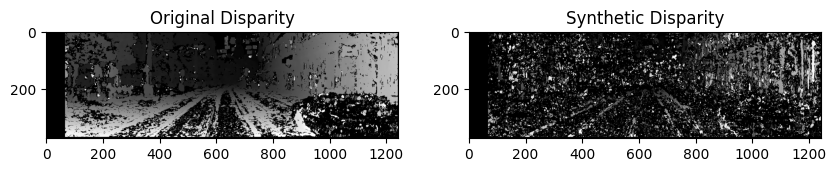

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Disparity")
plt.imshow(original_disparity, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Synthetic Disparity")
plt.imshow(synthetic_disparity, cmap="gray")
plt.show()
